## Preparing data

In [1]:
import xarray as xr
import geopandas as gpd
from dask.distributed import Client, LocalCluster
from datetime import datetime, timedelta
from functools import partial
from PyStemmusScope import variable_conversion as vc
from rasterio.warp import reproject, Resampling
import numpy as np
import glob
import dask.array as da
import pandas as pd
from dask_jobqueue import SLURMCluster

In [2]:
year = 2015

parent_in_path = f"/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data"
data_paths = {
            "era5land": f"{parent_in_path}/{year}global/era5land/era5-land_*.nc",
            "lai": f"{parent_in_path}/{year}global/lai_v2/*.nc",
            "ssm": f"{parent_in_path}/{year}global/ssm/GlobalGSSM11km2014_20240214.tif",
            "co2": f"{parent_in_path}/{year}global/co2/CAMS_CO2_2003-2020.nc",
            "landcover": f"{parent_in_path}/landcover/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2013-v2.0.7cds.nc",
            "vcmax": f"{parent_in_path}/Vcmax/TROPOMI_Vmax_Tg_mean.tif",
            "canopyheight": f"{parent_in_path}/canopy_height/canopy_height_11kmGlobal20240215.tif",
            }

parent_out_path = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/testSarah"

In [3]:
def era5_preprocess(ds):    
    # Convert the longitude coordinates from [0, 360] to [-180, 180]
    ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))
    
    return ds

def fix_coords(ds):
    if 'band' in ds.dims:
        ds = ds.rename_dims({'band': 'time'})
        ds = ds.rename_vars({'band': 'time'})

    if 'x' in ds.dims and 'y' in ds.dims:
        ds = ds.rename_dims({'x': 'longitude', 'y': 'latitude'})
        ds = ds.rename_vars({'x': 'longitude', 'y': 'latitude'})
        
    elif 'lon' in ds.dims and 'lat' in ds.dims:
        ds = ds.rename_dims({'lon': 'longitude', 'lat': 'latitude'})
        ds = ds.rename_vars({'lon': 'longitude', 'lat': 'latitude'})
    return ds

In [4]:
cluster = SLURMCluster(
    name='dask-worker',
    cores=16,
    processes=16,
    queue='fat',
    memory='120GiB',
    local_directory='$TMPDIR',
    walltime='3:00:00'
)
cluster.scale(jobs=4)
client = Client(cluster)
client

/home/qiahan/.conda/envs/mamba/envs/emulator/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41735 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/41735/status,
Dashboard: /proxy/41735/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://145.136.63.38:33811,Workers: 0
Dashboard: /proxy/41735/status,Total threads: 0
Started: Just now,Total memory: 0 B


## ERA5LAND

In [5]:
%%time
era5land = xr.open_mfdataset(data_paths['era5land'], preprocess=era5_preprocess, chunks={'longitude': 250, 'latitude': 250})
# era5land = era5land.chunk({'time': 750})
era5land = era5land.sortby(['longitude', 'latitude'])
era5land = era5land.chunk(
    time=750, 
    longitude=250, 
    latitude=250
)
# # svae to zarr
out_path = f"{parent_in_path}/{year}global/era5land/{'era5land'}_{year}.zarr"
era5land.to_zarr(out_path, mode='w')

CPU times: user 20min 20s, sys: 1min, total: 21min 21s
Wall time: 1h 25min 28s


In [6]:
client.shutdown()

In [7]:
out_path

'/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2013global/era5land/era5land_2013.zarr'

In [7]:
target = era5land['sp'].isel(time=0, drop=True)
target = target.rio.write_crs('EPSG:4326')

## CO2

In [36]:
%%time
## CO2
co2 = xr.open_dataset(data_paths['co2']).sel(time=str(year))
co2 = co2.assign_coords(longitude=(((co2.longitude + 180) % 360) - 180))     
co2 = co2.sortby(['longitude', 'latitude'])
co2 = vc.co2_mass_fraction_to_kg_per_m3(co2['co2'])*1e6 #kg/kg -> mg/m3

CPU times: user 15.1 ms, sys: 6.19 ms, total: 21.3 ms
Wall time: 80 ms


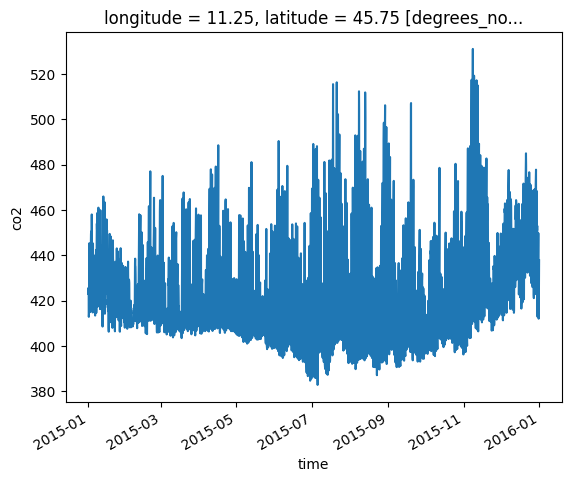

In [41]:
(co2['co2']*1.0e6 * 28.966 / 44.0).sel(longitude=vali0[vali0.station=='IT-Lav'].longitude.unique()[0],latitude=vali0[vali0.station=='IT-Lav'].latitude.unique()[0],method='nearest').plot()

In [8]:
vali0 = pd.read_csv("/projects/0/ttse0619/qianqian/global_data_Qianqian/3RF_train/testing_space-withindex_v6_hourlyUTC.csv") 
# vali = pd.read_csv("/projects/0/ttse0619/qianqian/global_data_Qianqian/5output_data/"+station+"_spaceVali.csv")


/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


<Axes: >

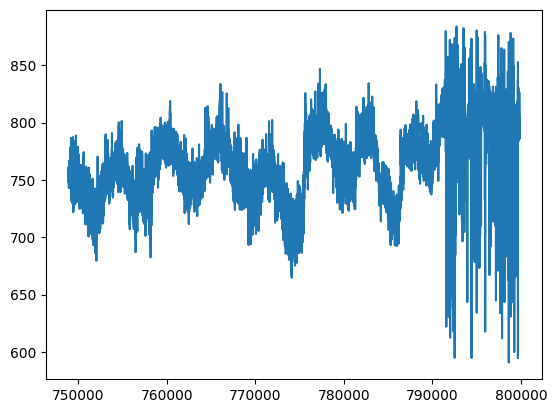

In [35]:
(vali0[vali0.station=='IT-Lav'].CO2).plot()

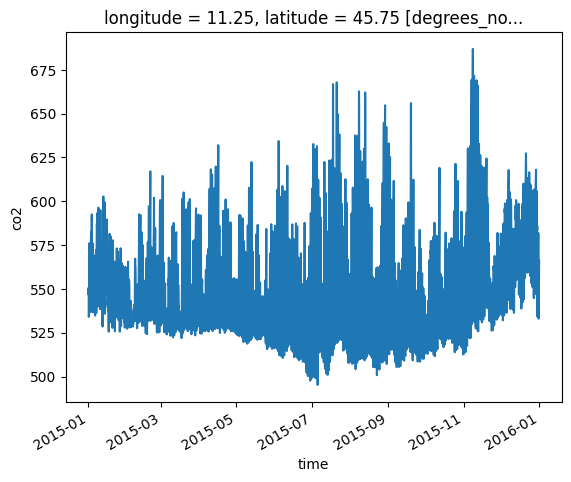

In [30]:

(co2*29/44).sel(longitude=vali0[vali0.station=='IT-Lav'].longitude.unique()[0],latitude=vali0[vali0.station=='IT-Lav'].latitude.unique()[0],method='nearest').plot()

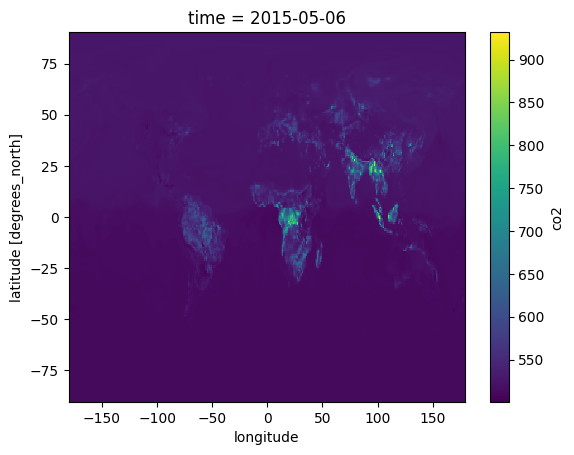

In [33]:

(co2*29/44)[1000].plot()

In [9]:
# co2 = co2.sel(time=slice('2014-01-01T00:00:00.000000000','2014-01-31T03:00:00.000000000'))

In [ ]:
%%time
co2 = co2.rio.write_crs('EPSG:4326')
co2.rio.write_nodata(co2.rio.nodata, inplace=True)
co2_reprojected = co2.rio.reproject_match(target, resampling=Resampling.average, nodata=np.nan)
co2_reprojected = co2_reprojected.assign_coords({
    "x": co2_reprojected.x,
    "y": co2_reprojected.y,
    'time':('time',co2_reprojected.time.values + np.timedelta64(3,'h'),co2_reprojected.time.attrs) # convert from starting time to ending time, same as ERA5Land
})
co2_reprojected = co2_reprojected.rename({'x':'longitude','y':'latitude'})


In [ ]:
%%time
co2_reprojected = co2_reprojected.chunk(
    time=-1, 
    longitude=250, 
    latitude=250
)
co2_reprojected = co2_reprojected.to_dataset(name='co2')


In [ ]:
co2_reprojected

In [11]:
%%time
# svae to zarr
out_path = f"{parent_in_path}/{year}global/co2/{'co2'}_{year}.zarr"
co2_reprojected.to_zarr(out_path, mode='w')

CPU times: user 1min 50s, sys: 46.6 s, total: 2min 37s
Wall time: 11.3 s


## LAI

In [7]:
LAI_DIR_before = (f"{parent_in_path}/{year-1}global/lai_v2/")
LAI_DIR_after = (f"{parent_in_path}/{year+1}global/lai_v2/")
LAI_DIR = (f"{parent_in_path}/{year}global/lai_v2/")
lai_paths_year = sorted(
    glob.glob(f'{LAI_DIR}/c_gls_LAI*_GLOBE_*.nc') #different from LAI_V1
)
lai_paths_before = sorted(
    glob.glob(f'{LAI_DIR_before}/c_gls_LAI*_GLOBE_*.nc')
)[-1]
lai_paths_after = sorted(
    glob.glob(f'{LAI_DIR_after}/c_gls_LAI*_GLOBE_*.nc')
)[0]
lai_paths = []
lai_paths.append(lai_paths_before)
lai_paths.extend(lai_paths_year)
lai_paths.append(lai_paths_after)

In [8]:
lai = xr.open_mfdataset(lai_paths, chunks={})
lai = lai['LAI']  # keep only one variable
lai.rio.write_nodata(np.nan, inplace=True)
lai = lai.rio.write_crs('WGS84')
lai = lai.rename(
    lon='longitude',
    lat='latitude',
)

In [14]:
template = xr.DataArray(
    data=da.zeros(
        (len(lai.time), len(target.latitude), len(target.longitude)),
        chunks=(1, -1, -1),
    ),
    dims=('time', 'latitude', 'longitude'),
    coords={
        'time': lai.time, 
        'latitude': target.latitude, 
        'longitude': target.longitude,
    },
)
def reproject(source):
    # import here, otherwise not seen by workers
    import rioxarray
    from rasterio.warp import reproject, Resampling
    reprojected = source.rio.reproject_match(
        target,
        nodata=np.nan,
        resampling=Resampling.average
    )
    reprojected = reprojected.drop_vars('crs')
    return reprojected.rename(x='longitude', y='latitude')

lai_reprojected = xr.map_blocks(
    reproject,
    lai,
    template=template,
)

In [19]:
%%time
lai_reprojected = lai_reprojected.chunk(
    time=-1, 
    longitude=250, 
    latitude=250
)
lai_reprojected = lai_reprojected.to_dataset(name='LAI')
# svae to zarr
out_path = f"{parent_in_path}/{year}global/lai_v2/{'lai_v2'}_{year}111.zarr"
lai_reprojected.to_zarr(out_path, mode='w')

CPU times: user 8.9 s, sys: 1.34 s, total: 10.2 s
Wall time: 10.7 s


In [24]:
print(lai_reprojected['latitude'].encoding)
print(lai_reprojected['longitude'].encoding)


{'source': '/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2014global/era5land/era5-land_2m_dewpoint_temperature_2014-01.nc', 'original_shape': (1801,), 'dtype': dtype('float32')}
{}


In [25]:
print(lai_reprojected['latitude'].dtype)  # 确认为 float64
print(lai_reprojected['longitude'].dtype)  # 确认为 float64

float64
float64


In [27]:
client.shutdown()

## SSM

In [24]:
%time
ssm = xr.open_dataset(data_paths['ssm'])
ssm = ssm.rio.write_crs('WGS84')
ssm = fix_coords(ssm)
ssm = ssm['band_data']
ssm['time'] = pd.to_datetime(ssm.time-1, unit='D', origin=str(data_paths['ssm'].split('/')[-1][14:18]))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


In [25]:
ssm.rio.write_nodata(np.nan, inplace=True)
SSM0 = ssm
SSM0 = SSM0.rio.write_crs('EPSG:4326')
target = target.rio.write_crs('EPSG:4326')
ssm.rio.write_nodata(SSM0.rio.nodata, inplace=True)
ssm_reprojected = SSM0.rio.reproject_match(target, resampling=Resampling.average, nodata=np.nan) #
ssm_reprojected = ssm_reprojected.rename(
    x='longitude',
    y='latitude',
)
# ssm_reprojected.isnull().sum()

In [ ]:
%%time
ssm_reprojected = ssm_reprojected.chunk(
    time=-1, 
    longitude=250, 
    latitude=250
)
ssm_reprojected = ssm_reprojected.to_dataset(name='SSM')

In [29]:
%%time
# svae to zarr
out_path = f"{parent_in_path}/{year}global/ssm/{'ssm_global'}_{year}.zarr"
ssm_reprojected.to_zarr(out_path, mode='w')

CPU times: user 19.8 s, sys: 6.83 s, total: 26.7 s
Wall time: 2.48 s


## landcover

In [30]:
landcover = xr.open_mfdataset(data_paths['landcover'])["lccs_class"]
landcover = landcover.rio.write_crs('WGS84')
landcover = landcover.rename(
    lon='longitude',
    lat='latitude',
)

In [31]:
landcover = landcover.rio.write_crs('EPSG:4326')
landcover.rio.write_nodata(landcover.rio.nodata, inplace=True)
landcover_reprojected = landcover.rio.reproject_match(target, resampling=Resampling.mode)
landcover_reprojected = landcover_reprojected.assign_coords({
    "x": landcover_reprojected.x,
    "y": landcover_reprojected.y,
})
# fix naming of coordinates
landcover_reprojected = landcover_reprojected.rename(
    x='longitude',
    y='latitude'
)

In [32]:
landcover_reprojected = landcover_reprojected.to_dataset(name='lccs_class')
landcover_reprojected = landcover_reprojected.chunk(
    longitude=250, 
    latitude=250
)

In [33]:
%%time
# svae to zarr
out_path = f"{parent_in_path}/landcover/{'landcover'}.zarr"
landcover_reprojected.to_zarr(out_path, mode='w')

CPU times: user 55.3 ms, sys: 57.9 ms, total: 113 ms
Wall time: 120 ms


## canopy height (hc)

In [34]:
hc = xr.open_dataset(data_paths['canopyheight']).band_data
# hc = hc.squeeze('band')  # drop band dimension
hc = hc.rio.write_crs('WGS84')
hc = hc.rename(
    x='longitude',
    y='latitude',
)
hc = hc.sortby(["longitude", "latitude"])

In [35]:
import numpy as np
hc.rio.write_nodata(np.nan, inplace=True)
hc = hc.rio.write_crs('EPSG:4326')
target = target.rio.write_crs('EPSG:4326')
hc_reprojected = hc.rio.reproject_match(target, resampling=Resampling.average, nodata=np.nan)
hc_reprojected = hc_reprojected.assign_coords({
    "x": hc_reprojected.x,
    "y": hc_reprojected.y,
})
# fix naming of coordinates
hc_reprojected = hc_reprojected.rename(
    x='longitude',
    y='latitude'
)

In [36]:
hc_reprojected = hc_reprojected.to_dataset(name='hc')
hc_reprojected = hc_reprojected.chunk(
    longitude=250, 
    latitude=250
)
# svae to zarr
out_path = f"{parent_in_path}/canopy_height/{'hc_global'}.zarr"
hc_reprojected.to_zarr(out_path, mode='w')

## Vcmax

In [37]:
vcmax = xr.open_dataset(data_paths['vcmax']).band_data
vcmax.rio.write_crs("EPSG:4326", inplace=True)
vcmax.rio.write_nodata(np.nan, inplace=True)

<xarray.DataArray 'band_data' (band: 1, y: 360, x: 720)>
[259200 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * y            (y) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        185.50468444824
    STATISTICS_MEAN:           32.584587871174
    STATISTICS_MINIMUM:        0.44747722148895
    STATISTICS_STDDEV:         30.55013573823
    STATISTICS_VALID_PERCENT:  20.61
    _FillValue:                nan

In [38]:
vcmax_fillna = vcmax.rio.interpolate_na(method='nearest') #interpolation method see: scipy.interpolate.griddata
vcmax_fillna = vcmax_fillna.rio.write_crs('WGS84')
vcmax_fillna = vcmax_fillna.rename(
    x='longitude',
    y='latitude',
)

In [39]:
vcmax_fillna_reprojected = vcmax_fillna.rio.reproject_match(target, resampling=Resampling.average, nodata=np.nan)
vcmax_fillna_reprojected = vcmax_fillna_reprojected.assign_coords({
    "x": vcmax_fillna_reprojected.x,
    "y": vcmax_fillna_reprojected.y,
})
# fix naming of coordinates
vcmax_fillna_reprojected = vcmax_fillna_reprojected.rename(
    x='longitude',
    y='latitude'
)

In [40]:
vcmax_fillna_reprojected = xr.where(target.notnull(), vcmax_fillna_reprojected, np.nan)
vcmax_fillna_reprojected_mask = vcmax_fillna_reprojected.where(vcmax_fillna_reprojected['latitude'] > -63, other=float('nan'))

In [41]:
vcmax_fillna_reprojected_mask = vcmax_fillna_reprojected_mask.to_dataset(name='vcmax')

In [43]:
%%time
vcmax_fillna_reprojected_mask = vcmax_fillna_reprojected_mask.chunk(
    longitude=250, 
    latitude=250
)
# svae to zarr
out_path = f"{parent_in_path}/Vcmax/{'vcmax_fillnan'}.zarr"
vcmax_fillna_reprojected_mask.to_zarr(out_path, mode='w')

CPU times: user 2min 18s, sys: 7min 41s, total: 9min 59s
Wall time: 8min 22s
